# Image Classification with CNNs

## Normal Setup/Imports

In [2]:
# Autoreload python modules before Python code run and plot inline
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# Import common machine learning libraries such as (numpy as np, pandas as pd, etc)
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

### Set path to data and size of images

In [4]:
PATH = '/home/paperspace/data/dogscats/'
size = 224

## Look at data

In [4]:
os.listdir(PATH)

['sample', 'valid', 'models', 'train', 'tmp', 'test1']

In [5]:
os.listdir(f'{PATH}valid')

['cats', 'dogs']

In [6]:
catfiles = os.listdir(f'{PATH}valid/cats')[:5]
dogfiles = os.listdir(f'{PATH}valid/dogs')[:5]
catfiles

['cat.11341.jpg',
 'cat.3869.jpg',
 'cat.5089.jpg',
 'cat.7380.jpg',
 'cat.11409.jpg']

In [7]:
dogfiles

['dog.2851.jpg',
 'dog.8500.jpg',
 'dog.7275.jpg',
 'dog.6665.jpg',
 'dog.1150.jpg']

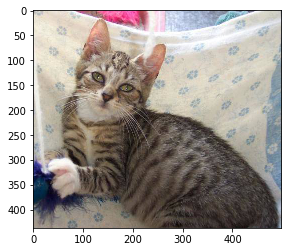

In [8]:
img = plt.imread(f'{PATH}valid/cats/{catfiles[0]}')
plt.imshow(img)

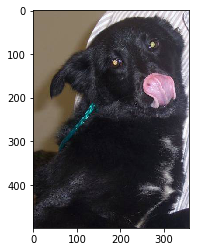

In [9]:
img = plt.imread(f'{PATH}valid/dogs/{dogfiles[0]}')
plt.imshow(img)

In [10]:
img.shape

(499, 357, 3)

### Load Architecture and Data

In [5]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=(tfms_from_model(arch, size)))

### Look at hist of image sizes

In [12]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [13]:
row_size, col_size = list(zip(*size_d.values()))

In [14]:
row_size = np.array(row_size)

In [15]:
col_size = np.array(col_size)

In [16]:
row_size[:5]

array([437, 443, 499, 273, 499])

In [17]:
col_size[:5]

array([453, 408, 375, 225, 332])

(array([ 193.,  934., 2459., 3071., 9772., 2434., 4135.,    0.,    0.,    2.]),
 array([ 32. , 105.6, 179.2, 252.8, 326.4, 400. , 473.6, 547.2, 620.8, 694.4, 768. ]),
 <a list of 10 Patch objects>)

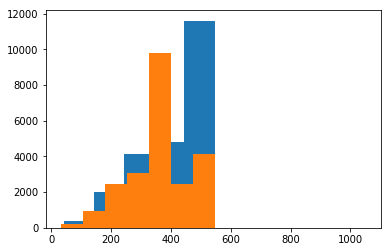

In [18]:
plt.hist(row_size); plt.hist(col_size)

The col and row sizes are mostly ~500 pixels or less which means when I scale it down to 224x224 the image should still recognizable. The cat and dog images are also in the center. Means I don't have to worry about cropping or scaling issues affecting a normal model's ability to detect important features.

## Find optimal learning rate and train my resnet34 model

In [19]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [20]:
learning_rate_finder = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 81%|████████  | 291/360 [00:06<00:01, 44.26it/s, loss=0.463]


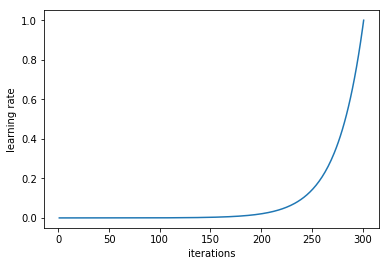

In [21]:
learn.sched.plot_lr()

This is showing the learning rates that were used during the previous fit (lr_find). It starts really small and then doubles the learning rate (I think it doubles ... may be some other rate increase).

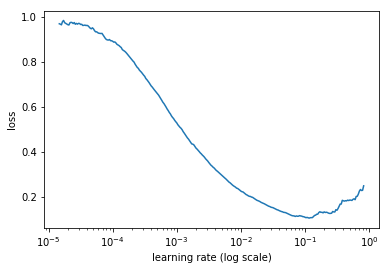

In [22]:
learn.sched.plot()

Goal is to select a learning rate where the slop is really sharp down but not too close to the minimum. .01 is a good selection.

Now to fit my model...

In [23]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2) #learningrate = 0.01, 2 epochs

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.047429   0.023067   0.991211  
    1      0.054859   0.023397   0.990723                     



[0.023397308, 0.99072265625]

## Analyzing the results

In [24]:
# Look at the labels and classes
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [25]:
data.classes # so cats is 0 and dogs is 1

['cats', 'dogs']

In [26]:
# Get the predictions for the val set. predictions are log probs by default
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [27]:
log_preds[1990:2000]

array([[-8.68924, -0.00017],
       [-9.09677, -0.00011],
       [-6.66479, -0.00128],
       [-8.88779, -0.00014],
       [-9.0138 , -0.00012],
       [-8.23584, -0.00027],
       [-9.03177, -0.00012],
       [-8.26967, -0.00026],
       [-6.46521, -0.00156],
       [-6.60286, -0.00136]], dtype=float32)

In [28]:
preds = np.argmax(log_preds, axis=1) # return index of the max value (ie 0 or 1 depending on cat or dog is more likely)

In [29]:
probs = np.exp(log_preds[:,1]) # probability of dog

In [22]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)

In [23]:
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y) == is_correct)

In [24]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])


In [25]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

In [26]:
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds, x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly Classified


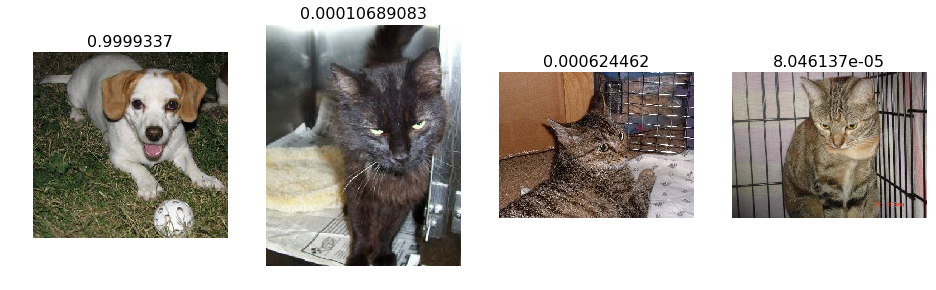

In [35]:
plot_val_with_title(rand_by_correct(True), "Correctly Classified")

Incorrectly Classified


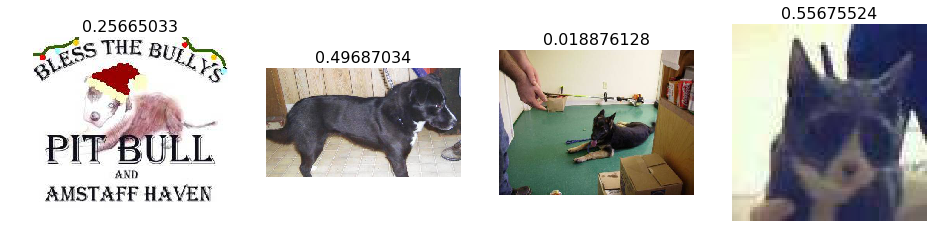

In [36]:
plot_val_with_title(rand_by_correct(False), "Incorrectly Classified")

In [27]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

In [28]:
def most_by_correct(y, is_correct):
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y) == is_correct) & (data.val_y == y), mult)

Most Correct Cats


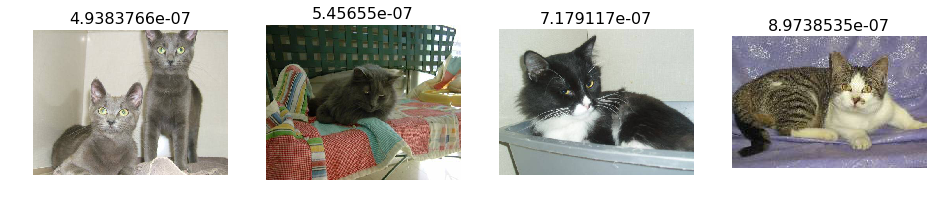

In [39]:
plot_val_with_title(most_by_correct(0, True), "Most Correct Cats")

Most Correct Dogs


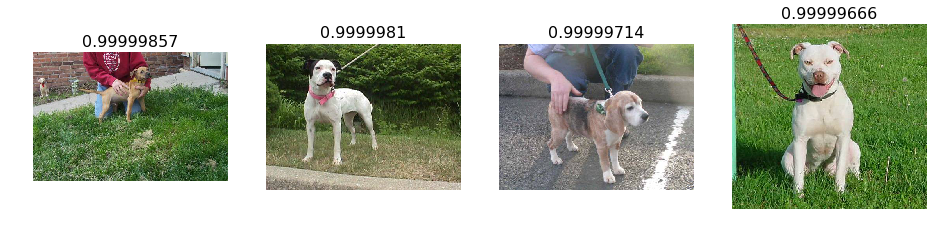

In [40]:
plot_val_with_title(most_by_correct(1, True), "Most Correct Dogs")

Most Wrong Cats


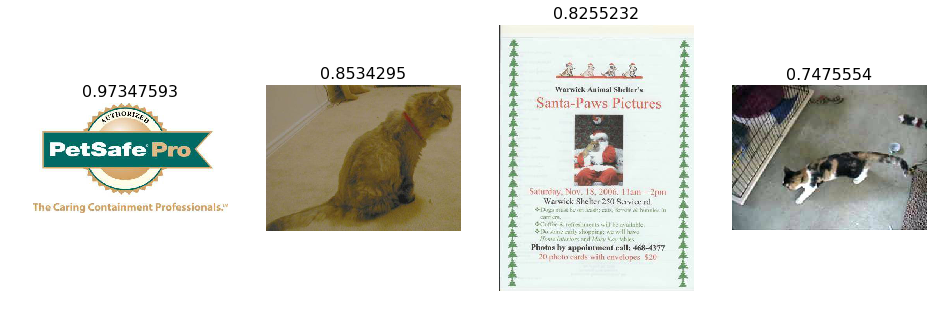

In [41]:
plot_val_with_title(most_by_correct(0, False), "Most Wrong Cats")

Most Wrong Dogs


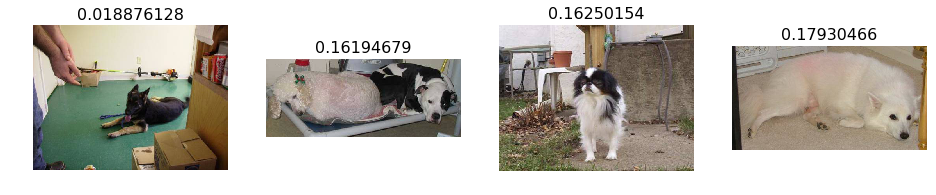

In [42]:
plot_val_with_title(most_by_correct(1, False), "Most Wrong Dogs")

Most Uncertain Predictions


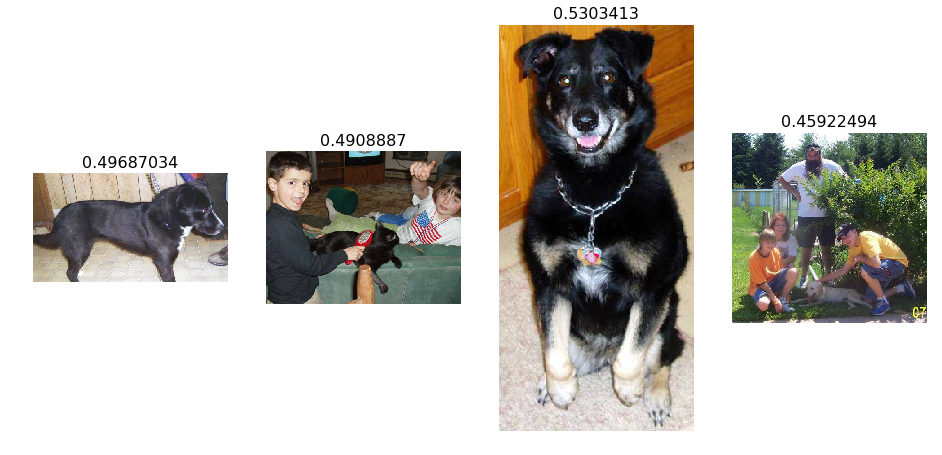

In [43]:
most_uncertain = np.argsort(np.abs(probs - 0.5))[:4]
plot_val_with_title(most_uncertain, "Most Uncertain Predictions")

## Improving the Model

### Augmentation

In [6]:
tfms = tfms_from_model(arch, size, aug_tfms=transforms_side_on, max_zoom=1.1)

In [49]:
def get_augs(tfms):
    data = ImageClassifierData.from_paths(PATH, bs=2, num_workers=1, tfms=tfms)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [51]:
ims = np.stack([get_augs(tfms) for i in range(6)])

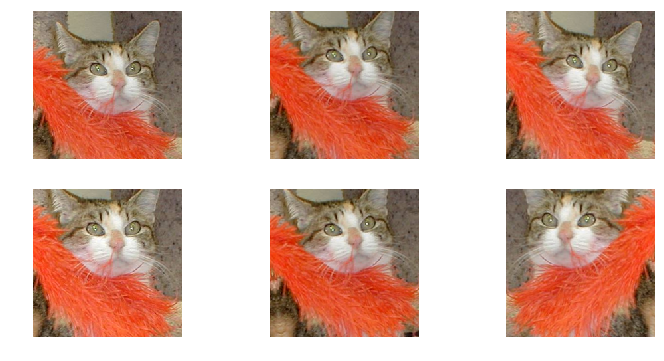

In [52]:
plots(ims, rows=2)

That looks like a good transform so let's apply it to the training set for real and refit

In [7]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [54]:
learn.fit(.01, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.051115   0.025596   0.992676  



[0.02559616, 0.99267578125]

Okay, that helped some. The augmented training set only helped the last layer since the resnet conv layers are frozen by default (for faster training). Later I'll unfreeze and retrain.
Just following the originally lesson I'm removing precompute and running 3 more epochs. It overtrains and just takes a while ...

In [55]:
learn.precompute = False
learn.fit(.01, 3, cycle_len=1) # cycle_len, when set to num, says how many epochs to go through before resetting the lrn_rate
# Normally the learn rate starts at [.01 or whatever] and decreases but restarting it could help it find a stable min
# which is a wide min as opposed to a deep V.

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.053884   0.023826   0.993652  
    1      0.041078   0.023213   0.990723                     
    2      0.040209   0.02201    0.990234                     



[0.02201029, 0.990234375]

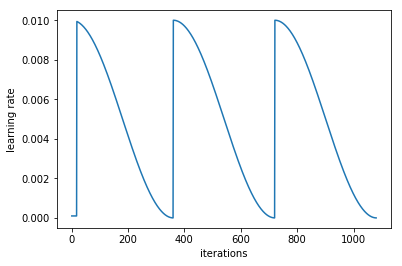

In [58]:
learn.sched.plot_lr()

In [56]:
learn.save('224_lastlayer') #how to save and reload

In [57]:
learn.load('224_lastlayer')

Finally unfreeze...

In [8]:
learn.unfreeze()

Good idea to give the first 1/3rd a lower learning rate, the middle 1/3rd a middling rate, and the last 1/3rd the same learning rate as before (from the lrn rate finder)

In [60]:
lr=np.array([.0001, .001, .01])

In [61]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.061471   0.021628   0.990723  
    1      0.042477   0.022288   0.990723                     
    2      0.028358   0.018127   0.992676                     
    3      0.027057   0.016988   0.994141                     
    4      0.024676   0.01724    0.993652                     
    5      0.023346   0.016031   0.993164                     
    6      0.018668   0.015371   0.993652                     



[0.01537082, 0.99365234375]

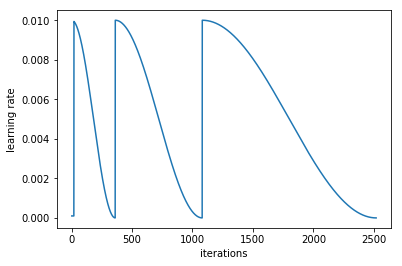

In [62]:
learn.sched.plot_lr()

In [65]:
learn.save('224_all')

In [9]:
learn.load('224_all')

### All about that TTA

TTA uses augmentation at inference (ie test) time. When making predictions, the model makes several augmented versions of the test image, runs inference and then takes the average prediction. Easy way to increase accuracy.

In [10]:
log_probs, y = learn.TTA()

In [18]:
probs = np.mean(np.exp(log_probs), 0)

In [21]:
accuracy_np(probs, y)

0.9945

## Analyzing Results (again)

In [30]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [31]:
from sklearn.metrics import confusion_matrix
confu_mat = confusion_matrix(y, preds)

[[994   6]
 [  5 995]]


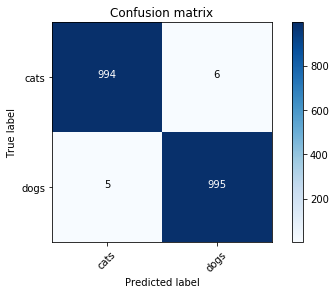

In [32]:
plot_confusion_matrix(confu_mat, data.classes)

Most Incorrect Cats


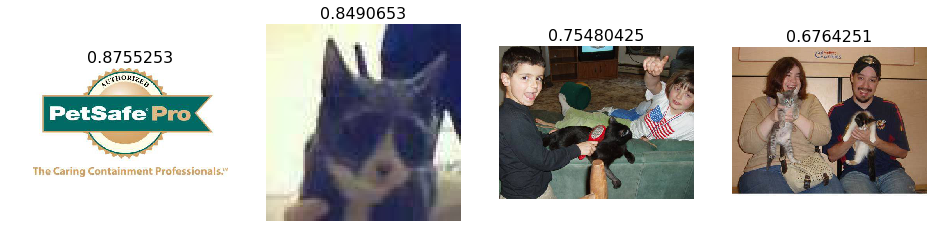

In [33]:
plot_val_with_title(most_by_correct(0, False), 'Most Incorrect Cats')

Most Incorrect Dogs


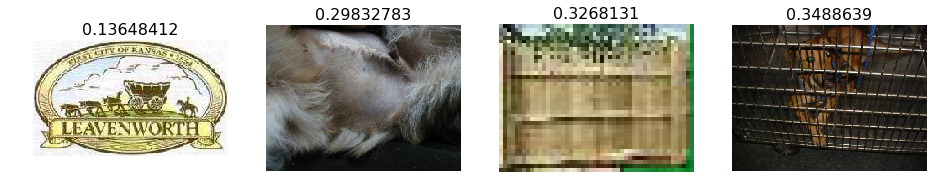

In [35]:
plot_val_with_title(most_by_correct(1, False), 'Most Incorrect Dogs')

That's it ... not too shabby. High accuracy even with some of the wrong images clearly aren't cats or dogs.